# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# импортирование всех нужных библиотек и фуцнкций 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import warnings

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

### Обзор данных

По первому взгляду на данные можно сказать:
* Необходимо изменить стиль заголовков на змеиный регистр
* Имеются пропущенные значения в признаках: 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired'.
* Неинформативные признаки, которые вряд ли повлияют на предсказания моделей: 'DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen'.
* Изменить тип данных на 'datetime64' у признаков : 'DateCrawled', 'DateCreated', 'LastSeen'.
* Можно поменять значения в признаке 'NotRepaired' с типа 'object' на тип 'Int64' для удобства. Значения 'yes' сменятся на 1, и значения 'no' аналогично на 0, смысл при этом сохранится.


In [3]:
# игнорирование предупреждений 
warnings.filterwarnings('ignore') 

# формирование датафрейма 
data = pd.read_csv('dataset_autos.csv', index_col=0)

# просмотр общей информации о датафрейме
display(data.head())
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Изменение стиля заголовков 

In [261]:
# изменение стиля заголовков
for name in data.columns:
    rena = re.sub(r"(?=[A-Z])(?!^)", '_', name).lower()
    data = data.rename(columns={name:rena})

# проверка внесенных изменений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

### Аномалии в данных

Во всех анкетах количество фотографий автомобиля равно нулю. Это вряд ли может соответствовать действительности, поэтому этот признак можно не учитывать во время обучения и предсказания моделей.

In [262]:
# просмотр значений признака
display(data['number_of_pictures'].value_counts())

# удаление признака
data = data.drop('number_of_pictures', axis=1)

0    354369
Name: number_of_pictures, dtype: int64

Объекты со значениями признака 'power' выше тысячи так же можно удалить, такие показатели мощности почти не встречаются в действитльности.

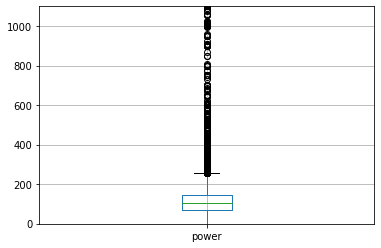

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

302

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
354062,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,2694,2016-03-21 10:42:49
354063,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
354064,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
354065,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26
354066,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,40764,2016-03-24 12:45:21


In [263]:
# диаграмма размаха
data.boxplot(column='power')
plt.ylim(-1, 1100)
plt.show()

# статистические данные признака
display(data['power'].describe())

# количество объектов с мощностью выше 1000
display(len(data[data['power'] > 1000]))

# удаление объектов с мощностью превышающей 1000
data = data.loc[data['power'] <= 1000].reset_index(drop=True)

# проверка внесенных изменений
display(data.tail())

Большое количество нулевых значений в целевом признаке 'price', это может негативно повлиять на предсказания моделей, поэтому лучше будет удалить объекты с нулевым значением.

In [264]:
# просмотр значений признака
display(data['price'].value_counts())

# удаление объектов с ценой равной нулю
data = data.loc[data['price'] != 0].reset_index(drop=True)

# проверка внесенных изменений
display(data.tail())

0        10756
500       5665
1500      5384
1000      4642
1200      4590
         ...  
5240         1
13180        1
10879        1
2683         1
8188         1
Name: price, Length: 3730, dtype: int64

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
343306,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,26624,2016-03-29 10:17:23
343307,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,39576,2016-04-06 00:46:52
343308,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,26135,2016-03-11 18:17:12
343309,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,87439,2016-04-07 07:15:26
343310,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,40764,2016-03-24 12:45:21


In [265]:
# изменение вида записи значений признака
data.loc[(data['not_repaired'] == 'no'), 'not_repaired'] = 0
data.loc[(data['not_repaired'] == 'yes'), 'not_repaired'] = 1

### Изменение типов данных

In [266]:
# изменение типов данных
data['date_crawled'] = pd.to_datetime(data['date_crawled'], format='%Y-%m-%d %H:%M:%S')
data['date_created'] = pd.to_datetime(data['date_created'], format='%Y-%m-%d %H:%M:%S')
data['last_seen'] = pd.to_datetime(data['last_seen'], format='%Y-%m-%d %H:%M:%S')

# проверка внесенных изменений
display(data.head())
data.info()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1,2016-03-24,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,2016-03-17,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,2016-03-31,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343311 entries, 0 to 343310
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        343311 non-null  datetime64[ns]
 1   price               343311 non-null  int64         
 2   vehicle_type        309602 non-null  object        
 3   registration_year   343311 non-null  int64         
 4   gearbox             325972 non-null  object        
 5   power               343311 non-null  int64         
 6   model               325824 non-null  object        
 7   kilometer           343311 non-null  int64         
 8   registration_month  343311 non-null  int64         
 9   fuel_type           313907 non-null  object        
 10  brand               343311 non-null  object        
 11  not_repaired        277547 non-null  object        
 12  date_created        343311 non-null  datetime64[ns]
 13  postal_code         343311 no

### Пропущенные значения

Объекты с пропусками в признаках 'vehicle_type', 'gearbox', 'model', 'fuel_type' можно удалить, так как их не большое количество, пропуски в признаке 'not_repaired' можно заполнить наиболее встречаемым значением.

In [267]:
# просмотр значений признака
display(data['not_repaired'].value_counts())

0    243538
1     34009
Name: not_repaired, dtype: int64

In [268]:
# список с признаками в которых присутствуют пропущенные значения 
nan_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type']

# удаление пропущенных значений в признаках из списка
data = data.dropna(subset=nan_columns).reset_index(drop=True)

# заполнение пропущенных значений и изменение типа данных признака 'not_repaired'
data['not_repaired'] = data['not_repaired'].fillna(0)
data['not_repaired'] = data['not_repaired'].astype(int)

# проверка внесенных изменений 
data.info()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278901 entries, 0 to 278900
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        278901 non-null  datetime64[ns]
 1   price               278901 non-null  int64         
 2   vehicle_type        278901 non-null  object        
 3   registration_year   278901 non-null  int64         
 4   gearbox             278901 non-null  object        
 5   power               278901 non-null  int64         
 6   model               278901 non-null  object        
 7   kilometer           278901 non-null  int64         
 8   registration_month  278901 non-null  int64         
 9   fuel_type           278901 non-null  object        
 10  brand               278901 non-null  object        
 11  not_repaired        278901 non-null  int64         
 12  date_created        278901 non-null  datetime64[ns]
 13  postal_code         278901 no

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen
0,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0,2016-03-14,90480,2016-04-05 12:47:46
1,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0,2016-03-17,91074,2016-03-17 17:40:17
2,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0,2016-03-31,60437,2016-04-06 10:17:21
3,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,1,2016-04-04,33775,2016-04-06 19:17:07
4,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,0,2016-04-01,67112,2016-04-05 18:18:39


## Выбор моделей

### Подготовка выборок

Так как тестовой выборки нет, разобьем исходнные данные в соотношении 3:1:1. <br>
Также проведем масштабирование признаков путем стандартизации.

#### Кодирование One-Hot Encoding (OHE)

In [269]:
# формирование датафрейма без столбцов не влияюших на целевой признак
data = data.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)
data_cat = data_cat.drop(['date_crawled', 'registration_month', 'date_created', 'postal_code', 'last_seen'], axis=1)

# кодирование OHE
data = pd.get_dummies(data, drop_first=True)

# проверка внесенных изменений
display(data.head())

,price,registration_year,power,kilometer,not_repaired,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,...,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo
0,9800,2004,163,125000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1500,2001,75,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3600,2008,69,90000,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,650,1995,102,150000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2200,2004,109,150000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [270]:
# формирование обучающей, валидационной и тестовой выборок
data_train, data_temporary = train_test_split(data, test_size=0.4, random_state=42)
data_valid, data_test = train_test_split(data_temporary, test_size=0.5, random_state=42)

# проверка соотношения размеров выборок
display(len(data_train), len(data_valid), len(data_test))

# признаки и целевой признак в обучающей выборке 
features_train = data_train.drop(['price'], axis=1)
target_train = data_train['price']

# признаки и целевой признак в валидационной выборке 
features_valid = data_valid.drop(['price'], axis=1)
target_valid = data_valid['price']

# признаки и целевой признак в тестовой выборке 
features_test = data_test.drop(['price'], axis=1)
target_test = data_test['price']

167340

55780

55781

### LightGBM

Показатели модели:
* RMSE: 1668.
* Затраченное время на обучение: 1 минута 52 секунды.
* Затраченное время на предсказание: 0.787 секунд.

In [271]:
%%time

# вариации гиперпараметров
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
n_estimators = [int(x) for x in np.linspace(10, 100, num = 3)]

# сетка гиперпараметров
param_grid = {'max_depth':max_depth,
              'n_estimators':n_estimators}

# модель 'LGBMRegressor'
model_lgb = GridSearchCV(LGBMRegressor(random_state=42), param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)

# обучение модели на обучающих данных 
model_lgb.fit(features_train, target_train)

CPU times: user 1min 45s, sys: 6.5 s, total: 1min 52s
Wall time: 1min 52s


GridSearchCV(cv=2, estimator=LGBMRegressor(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'n_estimators': [10, 55, 100]},
             scoring='neg_root_mean_squared_error')

In [272]:
%%time

# предсказания модели на валидационной выборке
pred_valid = model_lgb.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

1668.756466235816

CPU times: user 650 ms, sys: 40.7 ms, total: 690 ms
Wall time: 787 ms


### CatBoost

Показатели модели:
* RMSE: 1573.
* Затраченное время на обучение: 29 секунд.
* Затраченное время на предсказание: 0.072 секунды.

In [273]:
%%time

# вариации гиперпараметров
loss_function = ['RMSE']
depth = [int(x) for x in np.linspace(10, 50, num = 5)]
iterations = [int(x) for x in np.linspace(10, 100, num = 5)]

# сетка гиперпараметров
param_grid = {'depth':depth,
              'n_estimators':n_estimators,
              'loss_function':loss_function}

# модель 'CatBoostRegressor'
model_cat = GridSearchCV(CatBoostRegressor(), param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=2)

# обучение модели на обучающих данных 
model_cat.fit(features_train, target_train, verbose=25)

Learning rate set to 0.5
0:	learn: 3083.2648713	total: 35.2ms	remaining: 317ms
9:	learn: 1743.0327477	total: 325ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3100.7897045	total: 29.5ms	remaining: 266ms
9:	learn: 1735.5663412	total: 305ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 3083.2648713	total: 31.2ms	remaining: 1.69s
25:	learn: 1608.5551897	total: 778ms	remaining: 867ms
50:	learn: 1514.3087383	total: 1.53s	remaining: 120ms
54:	learn: 1503.8150279	total: 1.65s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3100.7897045	total: 31.4ms	remaining: 1.7s
25:	learn: 1600.3482412	total: 849ms	remaining: 947ms
50:	learn: 1507.9247898	total: 1.67s	remaining: 131ms
54:	learn: 1493.7636905	total: 1.8s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3083.2648713	total: 31.9ms	remaining: 3.16s
25:	learn: 1608.5551897	total: 809ms	remaining: 2.3s
50:	learn: 1514.3087383	total: 1.58s	remaining: 1.52s
75:	learn: 1454.2208475	total: 2.35s	remaining: 743ms
99:	learn: 1408.6529243	

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4fcd0e4af0>,
             param_grid={'depth': [10, 20, 30, 40, 50],
                         'loss_function': ['RMSE'],
                         'n_estimators': [10, 55, 100]},
             scoring='neg_root_mean_squared_error')

In [274]:
%%time

# предсказания модели на валидационной выборке
pred_valid = model_cat.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

1573.3299779431688

CPU times: user 75.2 ms, sys: 177 µs, total: 75.4 ms
Wall time: 72.3 ms


### Линейная регрессия

Показатели модели:
* RMSE: 2611.
* Затраченное время на обучение: 14 секунд.
* Затраченное время на предсказание: 0.2 секунды.

In [275]:
%%time

# модель 'LinearRegression'
model_lin_reg = LinearRegression()

# обучение модели на обучающих данных 
model_lin_reg.fit(features_train, target_train)

CPU times: user 10 s, sys: 3.87 s, total: 13.9 s
Wall time: 13.9 s


LinearRegression()

In [276]:
%%time

# предсказания модели на валидационной выборке
pred_valid = model_lin_reg.predict(features_valid)

# RMSE модели на валидационной выборке
display(mean_squared_error(target_valid, pred_valid, squared=False))

2611.715632990132

CPU times: user 97.3 ms, sys: 143 ms, total: 240 ms
Wall time: 200 ms


## Анализ моделей

Лучший результат по времени обучения показывает модель 'Линейная Регрессия': 14 секунд, а по метрике качества RMSE - 'CatBoostRegressor': 1573.<br>
Время предсказания неощутимо мало по сравнению с временем предсказания, но даже если его учитывать, то лидирует модель 'CatBoostRegressor'. <br>
Вместе с наилучшим результатом 'CatBoostRegressor' не так долго обучается в сравнении с 'LGBMRegressor', поэтому в этой задаче предпочтительнее выбрать 'CatBoostRegressor'.


In [281]:
# датафрейм с результатами моделей 
models_stats = pd.DataFrame(data={'time_train':[112, 29, 14], 
                                  'time_pred':[0.787, 0.072, 0.2], 
                                  'RMSE':[1668, 1573, 2611]}, 
                            index=['LGBMRegressor', 'CatBoostRegressor', 'LinearRegression'])
display(models_stats)

,time_train,time_pred,RMSE
LGBMRegressor,112,0.787,1668
CatBoostRegressor,29,0.072,1573
LinearRegression,14,0.200,2611


### Проверка выбранной модели на тестовой выборке

Итоговая метрика качества модели 'CatBoostRegressor' на тестовой выборке: 1589.

In [278]:
# предсказания модели 'CatBoostRegressor' на тестовой выборке
pred_test = model_cat.predict(features_test)

# RMSE модели на тестовой выборке
display(mean_squared_error(target_test, pred_test, squared=False))

1589.7416892326473

### Сравнение модели с константной

Выбранная модель показывает результат лучше нежели константная модель.

In [279]:
# константная модель
model_dummy = DummyRegressor(strategy='mean')

# обучение модели на обучающих данных 
model_dummy.fit(features_train, target_train)

# предсказания модели на тестовой выборке
pred_test = model_dummy.predict(features_test)

# RMSE модели на тестовой выборке
display(mean_squared_error(target_test, pred_test, squared=False))

4659.480258835881

## Вывод

* Изменили стили заголовков на змеиный регистр.
* Нашли аномалии в данных: в признаках 'number_of_pictures', 'power', 'price', 'not_repaired'.
* Изменили типы данных на более подходящии.
* Обработали пропущенные значения в признаках: 'vehicle_type', 'gearbox', 'model', 'fuel_type', 'not_repaired'.
* Разделили имеющиеся данные на обучающую, валидационную и тестовую выборки.
* Закодировали категориальные признаки техникой One-Hot Encoding.
* Рассмотрели три модели: 'LinearRegression', 'LGBMRegressor', 'CatBoostRegressor', из которых две последние - градиентный бустинг.
* По совокупному результату выбрали модель - 'CatBoostRegressor'
* Проверили выбранную модель (СatBoostRegressor) на тестовой выборке.
* Сравнили результаты константной и выбранной модели, CatBoostRegressor показал результаты лучше.